In [1]:
import pandas as pd 
import numpy as np 
from sklearn import preprocessing 

## Import Data ## 

# Import training set 
with open('train_with_label.txt') as file:
    train_buffer = file.readlines()
    train = pd.DataFrame([row.split('\t') for row in train_buffer], columns=['ID', 'sentence1', 'sentence2', 'groundTruth'])
    train.groundTruth = train.groundTruth.apply(lambda x: int(x.rstrip()))

# Import dev set 
with open('dev_with_label.txt') as file:
    dev_buffer = file.readlines()
    dev = pd.DataFrame([row.split('\t') for row in dev_buffer], columns=['ID', 'sentence1', 'sentence2', 'groundTruth'])
    dev.groundTruth = dev.groundTruth.apply(lambda x: int(x.rstrip()))

# Import testing set 
with open('test_without_label.txt') as file:
    test_buffer = file.readlines()
    test = pd.DataFrame([row.split('\t') for row in test_buffer], columns=['ID', 'sentence1', 'sentence2']) 

# Print out shapes 
print("Dev With Label Shape: " + str(dev.shape)) 
print("Train With Label Shape: " + str(train.shape)) 
print("Test Without Label Shape: " + str(test.shape)) 


Dev With Label Shape: (724, 4)
Train With Label Shape: (4077, 4)
Test Without Label Shape: (1000, 3)


In [2]:
import nltk 
from Levenshtein import distance as lev 
from nltk.stem import WordNetLemmatizer 

## Generate Features ## 

# Function: Generate features provided two sentences 
def featureCreation(frame): # Pass in the information  
    df = pd.DataFrame(frame) # Convert to dataFrame 
    
    # Vectorize each sentence and clean each element 
    df['words1'] = df['sentence1'].str.replace('[^\'0-9A-Za-z ]+', '').str.lower().str.replace(" '", "'").str.replace("  ", " ").str.split(' ') 
    df['words2'] = df['sentence2'].str.replace('[^\'0-9A-Za-z ]+', '').str.lower().str.replace(" '", "'").str.replace("  ", " ").str.split(' ')
    
    # Find commonality between words 
    lemmatizer = WordNetLemmatizer() 
    df['words1'] = df.apply(lambda x: ([lemmatizer.lemmatize(word) for word in x['words1']]), axis = 1) 
    df['words2'] = df.apply(lambda x: ([lemmatizer.lemmatize(word) for word in x['words2']]), axis = 1) 

    # Find the number of words in common, then divide by the average number of words between the two sentences 
    df['WordsInCommon/AverageLen'] = df.apply(lambda x: (len(np.intersect1d(x['words1'],x['words2']))) / (len(x['words1']) + len(x['words2']))/2, axis = 1)
    
    # Obtain the difference in length between the two sentences 
    df['differenceInLength'] = df.apply(lambda x: abs(len(x['words1']) - len(x['words2'])), axis = 1)

    ## Subset Function ## 
    # This sub-function counts the number of times each sequential subset of words of length "difference", appear in both sentences. 
    # e.g. Difference = 2 
    #      Sentence 1: How are you? Sentence 2: Who are you? 
    #                  how are you              who are you 
    #     subset_1    [how are]             != [who are], != [are you] 
    #     subset_2    [are you]             != [who are],  = [are you] 
    #     Output = 1 
    def subsetCounter(a, b, difference): 
        count = 0 
        for i in range(len(a) - difference - 1): # Create a subset from a 
            subset1 = a[i:(i + difference)] 
            for j in range(len(b) - difference - 1): # See if this subset is in b 
                subset2 = b[j:(j + difference)] 
                if(subset1 == subset2): 
                    count = count + 1 
                    # print("Subset1: " + str(subset1) + "\tSubset2: " + str(subset2)) # Test 
        return count 

    # Sub-function to return maximum between (a,b) and (b,a) 
    def subsetWords(a, b, difference): 
        count1 = subsetCounter(a, b, difference) 
        count2 = subsetCounter(b, a, difference) 
        return np.maximum(count1, count2)
    
    # Apply the above sub-functions for subsets of length 2, 3, 4, 5, and 6 
    df['subsets2'] = df.apply(lambda x: subsetWords(x['words1'], x['words2'], 2) / ((len(x['words1']) + len(x['words1'])) / 2), axis = 1) 
    df['subsets3'] = df.apply(lambda x: subsetWords(x['words1'], x['words2'], 3) / ((len(x['words1']) + len(x['words1'])) / 2), axis = 1) 
    df['subsets4'] = df.apply(lambda x: subsetWords(x['words1'], x['words2'], 4) / ((len(x['words1']) + len(x['words1'])) / 2), axis = 1) 
    df['subsets5'] = df.apply(lambda x: subsetWords(x['words1'], x['words2'], 5) / ((len(x['words1']) + len(x['words1'])) / 2), axis = 1)
    df['subsets6'] = df.apply(lambda x: subsetWords(x['words1'], x['words2'], 6) / ((len(x['words1']) + len(x['words2'])) / 2), axis = 1)

    # BiLingual Evaluation Understudy Score 
    df['Bleu Score'] = df.apply(lambda x: nltk.translate.bleu_score.sentence_bleu([x['words1']], x['words2'], weights = (1, 0, 0, 0)), axis = 1) 

    # Levenshtein Score 
    df['Levenshtein'] = 0
    for i in range(len(df)): 
        df['Levenshtein'].iloc[i] = lev(df['words1'].iloc[i], df['words2'].iloc[i]) / ((len(df['words1'].iloc[i]) + len(df['words2'].iloc[i])) / 2) 
    
    # Uncommon words in common score / length score: 
    with open('1-1000.txt') as file:
        test_buffer = file.readlines()
#       dictionary250 = pd.DataFrame([row.split('\n') for row in test_buffer], columns=['Word', 'Null']).head(250)
#       dictionary250 = set(dictionary250['Word']) # Convert to set 
        dictionary1000 = pd.DataFrame([row.split('\n') for row in test_buffer], columns=['Word', 'Null']).head(1000)
        dictionary1000 = set(dictionary1000['Word']) # Convert to set 
    
#     df['words1_Outside_dictionary250'] = df['words1'].apply(lambda x: list(filter(None, set(x).difference(dictionary250)))) 
#     df['words2_Outside_dictionary250'] = df['words2'].apply(lambda x: list(filter(None, set(x).difference(dictionary250))))
#     df['Outside_dictionary250_Common / Length'] = df.apply(lambda x: (len(np.intersect1d(x['words1_Outside_dictionary250'],x['words2_Outside_dictionary250']))) / (len(x['words1_Outside_dictionary250']) + len(x['words2_Outside_dictionary250']) + 1)/2, axis = 1)
    
    df['words1_Outside_dictionary1000'] = df['words1'].apply(lambda x: list(filter(None, set(x).difference(dictionary1000)))) 
    df['words2_Outside_dictionary1000'] = df['words2'].apply(lambda x: list(filter(None, set(x).difference(dictionary1000))))
    df['Outside_dictionary1000_Common / Length'] = df.apply(lambda x: (len(np.intersect1d(x['words1_Outside_dictionary1000'],x['words2_Outside_dictionary1000']))) / (len(x['words1_Outside_dictionary1000']) + len(x['words2_Outside_dictionary1000']) + 1)/2, axis = 1)
    
    return df

In [3]:
import matplotlib.pyplot as plt 
from sklearn import linear_model 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.utils import resample 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Generate the features the datasets: 
train = featureCreation(train) 
dev = featureCreation(dev) 
test = featureCreation(test) 

# Upsampling: 
print("Number of zeros in the training set: " + str((train['groundTruth'] == 0).sum())) 
print("Number of ones in the training set: " + str((train['groundTruth'] == 1).sum())) 

# Thus, an upsampling must be preformed: 
zeros = train[train['groundTruth'] == 0] 
ones = train[train['groundTruth'] == 1]
zeros = resample(zeros, replace = True, n_samples = len(ones), random_state = 1)
train = pd.concat([zeros, ones]) 

print("New number of zeros in the training set: " + str((train['groundTruth'] == 0).sum())) 
print("New number of ones in the training set: " + str((train['groundTruth'] == 1).sum())) 

# Set features that will be used in the model:  
# Dropped differentInLength 
X_train = train[['WordsInCommon/AverageLen', 'subsets2', 'subsets3', 'subsets4', 'subsets5', 'subsets6', 'Bleu Score', 'Levenshtein', 'Outside_dictionary1000_Common / Length']] 
y_train = train['groundTruth'] 
X_dev = dev[['WordsInCommon/AverageLen', 'subsets2', 'subsets3', 'subsets4', 'subsets5', 'subsets6', 'Bleu Score', 'Levenshtein', 'Outside_dictionary1000_Common / Length']]
y_dev = dev['groundTruth'] 
X_test = test[['WordsInCommon/AverageLen', 'subsets2', 'subsets3', 'subsets4', 'subsets5', 'subsets6', 'Bleu Score', 'Levenshtein', 'Outside_dictionary1000_Common / Length']] 

# Normalize the data: 
scaler = MinMaxScaler() 
X_train = scaler.fit_transform(X_train) 
X_dev = scaler.transform(X_dev) 


/var/folders/jq/drn2hrr90kv396cxlgjbbryw0000gn/T/ipykernel_14770/891423711.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['words1'] = df['sentence1'].str.replace('[^\'0-9A-Za-z ]+', '').str.lower().str.replace(" '", "'").str.replace("  ", " ").str.split(' ')
/var/folders/jq/drn2hrr90kv396cxlgjbbryw0000gn/T/ipykernel_14770/891423711.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['words2'] = df['sentence2'].str.replace('[^\'0-9A-Za-z ]+', '').str.lower().str.replace(" '", "'").str.replace("  ", " ").str.split(' ')
/Users/christopherschenk/opt/anaconda3/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/U

Number of zeros in the training set: 1039
Number of ones in the training set: 3038
New number of zeros in the training set: 3038
New number of ones in the training set: 3038


Accuracy :  0.75
Accuracy Percentage (%) :  75.0
The following is adjusted by resampling in the cell above. 
Number of zeros predicted: 411
Number of ones predicted: 313


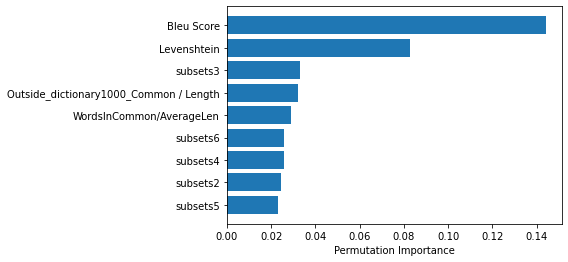

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from numpy import mean 
from numpy import std 

# SVM Model 
model4 = SVC(kernel = 'rbf', probability = True, C = 10, gamma = .7) 
model4.fit(X_train, y_train)
y_pred = model4.predict(X_dev) 

accuracy = metrics.accuracy_score(y_dev, y_pred)
accuracy_percentage = 100 * accuracy 

print('Accuracy : ', accuracy) 
print("Accuracy Percentage (%) : ", accuracy_percentage) 

# Test Feature Importance: 
perm_importance = permutation_importance(model4, X_dev, y_dev)

feature_names = ['WordsInCommon/AverageLen', 'subsets2', 'subsets3', 'subsets4', 'subsets5', 'subsets6', 'Bleu Score', 'Levenshtein', 'Outside_dictionary1000_Common / Length']
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance") 

print("The following is adjusted by resampling in the cell above. ") 
print("Number of zeros predicted: " + str((y_pred == 0).sum())) 
print("Number of ones predicted: " + str((y_pred == 1).sum())) 


In [5]:
# Output Prediciton for the testing set: 
y_pred = model4.predict(X_test) 

# Create submission file: 
test['y_pred'] = y_pred.tolist() 
submission = test[['ID', 'y_pred']] 
submission.to_csv('Will_Schenk_test_result.txt', sep ='\t', header = False, index = False)


# This can be made 500, and 500 by upsampling the number of ones in the testing set. 
# But, this will decrease the accuracy in the dev set. 
# I used KFold Cross validation, which returned the same accuracy, so overfitting is not an issue. 
# Instead, the majority of 0 samples are correctly classified, and the majority of sample classified as 1, are 1. 

print("Number of zeros predicted: " + str((y_pred == 0).sum())) 
print("Number of ones predicted: " + str((y_pred == 1).sum())) 


Number of zeros predicted: 777
Number of ones predicted: 223
